## Toxic Comment Classification Using Deep Learning

Study of negative online behaviour. We need to be able to classify text and discern between different levels of toxicity and disrespectful behaviour - such as like threats, obscenity, insults, and identity-based hate etc

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

raw_data = pd.read_csv('../data/train.csv', encoding="utf-8")
display(raw_data.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Word2Vec

Vectorize the text

In [2]:
import nltk
import sklearn
import gensim
from nltk import word_tokenize, sent_tokenize
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
import matplotlib.pyplot as plt                        
%matplotlib inline

class vectorizer(object):
    def __init__(self, vector_method, size, sg, window, min_count, seed, workers, sents):
        self._vector_method = vector_method
        self._size = size
        self._sg = sg
        self._window = window
        self._min_count = min_count
        self._seed = seed
        self._sents = sents
        self._workers = workers
        
    def vectorize_model(self):
        model = self._vector_method(sentences=self._sents, size=self._size, sg=self._sg,
                 window=self._window, min_count=self._min_count, seed=self._seed,
                 workers=self._workers)
        
        return model
        

In [3]:
# print(raw_data['comment_text'][:2])
def parse_sentences():
    sentences = []
    for index, row in raw_data.iterrows():
        text = row['comment_text']
        sent = list(sent_tokenize(text.lower()))
        sentences.append(sent)

    return sentences

def word_process(some_text):
    stop_words = set(stopwords.words('english'))    
    words = word_tokenize(some_text[0].lower())
    
    filtered_words = []
    for w in words:
        if w not in stop_words:
            filtered_words.append(w)
            
    return list(words) 

def parse_raw():
    documents = []
    sents = parse_sentences()
    for sent in sents:
        processed = word_process(sent)
        documents.append(processed)
    
    return documents

sentences = parse_raw()
# print(sentences)

word2vec_method = vectorizer(Word2Vec, 64, 1, 10, 3, 42, 2, sentences)
word2vec_model = word2vec_method.vectorize_model()
print('done processing')


done processing


In [ ]:
# print(word2vec_model.wv.vocab)
# print(word2vec_model['fuck'])
print(word2vec_model.most_similar('fuck'))

In [ ]:
tsne = TSNE(n_components=2, n_iter=300)

X = word2vec_model[word2vec_model.wv.vocab]
X_2d = tsne.fit_transform(X)
coords_df = pd.DataFrame(X_2d, columns=['x', 'y'])
coords_df['token'] = word2vec_model.wv.vocab.keys()

print(coords_df.head())

# Plot the graph.
coords_df.plot.scatter('x', 'y', figsize=(8,8),
                       marker='o', s=10, alpha=0.2)

We define the features and labels

In [4]:
# clean up the docs and labels a bit
all_docs = list(raw_data['comment_text'])
all_labels = np.array(list(raw_data['toxic']))

def retrieve_toxic_data():
    toxic_docs = []
    toxic_labels = []
    for index, row in raw_data.iterrows():
        if int(row['toxic']) == 1:
            toxic_docs.append(row['comment_text'])
            toxic_labels.append(raw_data.iloc[index,3:])
            
    return toxic_docs, np.array(toxic_labels), len(toxic_docs)

toxic_docs, toxic_labels, toxic_entries = retrieve_toxic_data()    

print(toxic_docs[:2])
print(toxic_labels[:6])
print(toxic_entries)

['COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK', 'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...']
[[1 1 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 1 1]
 [0 1 0 1 0]
 [0 0 0 0 0]]
15294


### Feed-forward neural network

In [5]:
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

class neural_network(object):
    def __init__(self, docs, labels, epochs, batch_size, dropout):
        self._model = Sequential()
        self._docs = docs
        self._labels = labels
        self._epochs = epochs
        self._batch_size = batch_size
        self._dropout = dropout
     
    def split_data(self, docs, targets):
        length = len(docs)
        split_point = int(round(length * 0.8))
        return docs[:split_point], targets[:split_point], docs[split_point:], targets[split_point:]
        
    def prepare_docs(self, max_length):
        t = Tokenizer(num_words=5000)
        t.fit_on_texts(self._docs)
        vocab_size = len(t.word_index) + 1
        encoded_docs = t.texts_to_sequences(self._docs)
        padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
        return padded_docs, t
    
    # only put in top 5000 words?
    def calc_embedding_matrix(self, vocab_size, t):
        embedding_matrix = np.zeros((vocab_size, 64))
        for word, i in t.word_index.items():
            if word in word2vec_model.wv.vocab:
                embedding_vector = word2vec_model.wv[word]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                
        return embedding_matrix
    
    def construct_model(self, vocab_size, max_length, embedding_matrix):
        
        embedding_layer = Embedding(vocab_size, 64, weights=[embedding_matrix], input_length=max_length)
        embedding_layer.trainable = False
        
        self._model.add(embedding_layer)
        self._model.add(Flatten())
        self._model.add(Dense(64, activation='relu'))
        self._model.add(Dense(64, activation='relu'))
        self._model.add(Dropout(self._dropout))
        self._model.add(Dense(1, activation='sigmoid'))
        self._model.summary()
        
    def compile_model(self):
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self._model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
        checkpointer = ModelCheckpoint(filepath='saved_models/weights.feed_forward_network.hdf5', 
                               verbose=1, save_best_only=True)
        
        return checkpointer
        
    def train_save_model(self, train_docs, train_targets, valid_docs, valid_targets, checkpointer):
        trained_model = self._model.fit(train_docs, train_targets, validation_data=(valid_docs, valid_targets), 
                          epochs=self._epochs, batch_size=self._batch_size, callbacks=[checkpointer], verbose=1)

        with open('pickles/feed_forward_network', 'wb') as file_pi:
            pickle.dump(trained_model.history, file_pi)
            
        return trained_model
            
    def get_model(self):
        return self._model

Using TensorFlow backend.


In [ ]:
feed_forward_network = neural_network(all_docs, all_labels, 8, 32, 0.5)
padded_docs, t = feed_forward_network.prepare_docs(150)

In [ ]:
embedding_matrix = feed_forward_network.calc_embedding_matrix(len(t.word_index) + 1, t)
# print(embedding_matrix)

In [ ]:
train_valid_docs, train_valid_targets, test_docs, test_targets = feed_forward_network.split_data(padded_docs, all_labels)
train_docs, train_targets, valid_docs, valid_targets = feed_forward_network.split_data(train_valid_docs, train_valid_targets)

In [ ]:
feed_forward_network.construct_model(len(t.word_index) + 1, 150, embedding_matrix)

In [ ]:
checkpointer = feed_forward_network.compile_model()

In [ ]:
trained_feed_forward_model = feed_forward_network.train_save_model(train_docs, train_targets, valid_docs, valid_targets, checkpointer)

### Get the predictions and evaluate the accuracy

In [6]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

# test_docs, test_targets

class predictive_evaluate(object):
    def __init__(self, test_docs, test_targets, model):
        self._test_docs = test_docs
        self._test_targets = test_targets
        self._model = model
        
    def get_predictions(self):
        predictions = []
        for doc in self._test_docs:
            result = self._model.predict(np.expand_dims(doc, axis=0))
            preds = result[0][0]
            predictions.append(1 if preds >= 0.5 else 0)
                    
        return predictions
    
    def get_multilabel_predictions(self):
        predictions = []
        for doc in self._test_docs:
            result = self._model.predict(np.expand_dims(doc, axis=0))
            preds = result[0]
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0 
            predictions.append(preds)
                    
        return predictions
        
    def get_metrics(self, predictions):
        # print(self._test_targets[0])
        # print(predictions[0])
        model_recall_score = recall_score(self._test_targets, predictions, average='weighted')
        model_precision_score = precision_score(self._test_targets, predictions, average='weighted')
        model_f1_score = f1_score(self._test_targets, predictions, average='weighted')
        
        return model_recall_score, model_precision_score, model_f1_score
        

In [ ]:
model = feed_forward_network.get_model()
model.load_weights('saved_models/weights.feed_forward_network.hdf5')

evaluation = predictive_evaluate(test_docs, test_targets, model)
predictions = np.array(evaluation.get_predictions()).astype(int)

print(predictions[100:110])

In [ ]:
model_recall_score = recall_score(np.array(test_targets), predictions, average='weighted')
model_precision_score = precision_score(np.array(test_targets), predictions, average='weighted')
model_fbeta_score = fbeta_score(np.array(test_targets), predictions, average='weighted', beta=1)

print('Recall score:', model_recall_score)
print('Precision score:', model_precision_score)
print('F-beta score:', model_fbeta_score)

### Try a convolutional neural network

In [7]:
from keras.layers import Conv1D, SpatialDropout1D, GlobalMaxPool1D, MaxPooling1D
from keras.optimizers import SGD

class cnn_neural_network(neural_network):
    def __init__(self, docs, labels, epochs, batch_size, dropout, pad, drop_embed, n_conv, k_conv):
        super(cnn_neural_network, self).__init__(docs, labels, epochs, batch_size, dropout)
        self._pad = pad
        self._drop_embed = drop_embed
        self._n_conv = n_conv
        self._k_conv = k_conv
        
    def prepare_docs(self, max_length):
        t = Tokenizer(num_words=5000)
        t.fit_on_texts(self._docs)
        vocab_size = len(t.word_index) + 1
        encoded_docs = t.texts_to_sequences(self._docs)
        padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding=self._pad, truncating=self._pad, value=0)
        return padded_docs, t
    
    def construct_model(self, vocab_size, max_length, embedding_matrix):
        
        embedding_layer = Embedding(vocab_size, 64, weights=[embedding_matrix], input_length=max_length)
        embedding_layer.trainable = False
        
        self._model.add(embedding_layer)
        self._model.add(SpatialDropout1D(self._drop_embed))
        self._model.add(Conv1D(self._n_conv, self._k_conv, activation='relu'))
        self._model.add(MaxPooling1D(pool_size = 2))
        self._model.add(Conv1D(self._n_conv * 2, self._k_conv, activation='relu'))
        self._model.add(MaxPooling1D(pool_size = 2))
        self._model.add(Conv1D(self._n_conv * 4, self._k_conv, activation='relu'))
        self._model.add(GlobalMaxPool1D())
        self._model.add(Dense(self._n_conv, activation='relu'))
        self._model.add(Dropout(self._dropout))
        self._model.add(Dense(1, activation='sigmoid'))
        self._model.summary()
        
    def construct_toxic_model(self, vocab_size, max_length, embedding_matrix):
        
        embedding_layer = Embedding(vocab_size, 64, weights=[embedding_matrix], input_length=max_length)
        embedding_layer.trainable = False
        
        self._model.add(embedding_layer)
        self._model.add(SpatialDropout1D(self._drop_embed))
        self._model.add(Conv1D(self._n_conv, self._k_conv, activation='relu'))
        self._model.add(MaxPooling1D(pool_size = 2))
        self._model.add(Conv1D(self._n_conv * 2, self._k_conv, activation='relu'))
        self._model.add(GlobalMaxPool1D())
        self._model.add(Dense(self._n_conv, activation='relu'))
        self._model.add(Dropout(self._dropout))
        self._model.add(Dense(1, activation='sigmoid'))
        self._model.summary()
        
    def compile_model(self, model_name):
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self._model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
        checkpointer = ModelCheckpoint(filepath='saved_models/' + model_name, 
                               verbose=1, save_best_only=True)
        
        return checkpointer
        
    def train_save_model(self, train_docs, train_targets, valid_docs, valid_targets, checkpointer, model_name):
        trained_model = self._model.fit(train_docs, train_targets, validation_data=(valid_docs, valid_targets), 
                          epochs=self._epochs, batch_size=self._batch_size, callbacks=[checkpointer], verbose=1)

        with open('pickles/cnn_network' + model_name, 'wb') as file_pi:
            pickle.dump(trained_model.history, file_pi)
            
        return trained_model
            
    def get_model(self):
        return self._model
    

In [8]:
# downsampling
def downsample(docs, labels):
    downsample_index = 0
    for index, label in enumerate(labels):
        if int(label) == 1 and int(labels[index + 1]) == 0:
            del docs[index + 1]
            del labels[index + 1]
            
    return docs, np.array(labels) , len(docs)

def filter_df(filter_limit, raw_df):
    dataframe = raw_df.copy()
    dataframe = dataframe.sort_values('toxic', ascending=True)
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.iloc[filter_limit:]

    return dataframe.sample(frac=1).reset_index(drop=True)
        
dataframe = filter_df(100000, raw_data)
display(dataframe.head())
display(dataframe.describe())

shrink_docs = list(dataframe['comment_text'])
shrink_labels = np.array(list(dataframe['toxic']))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,bec22a677e0afa79,"""\n\n Please do not intentionally introduce in...",0,0,0,0,0,0
1,5b032165008c0ec0,"""\n\n Niggard PLEASE! \n\nThe niggardly nigger...",1,0,1,1,1,1
2,a3473233fd5ab0d6,Vijayawada\nThe edit here seems to be an assum...,0,0,0,0,0,0
3,7219fe942714bc03,Thanks for noting this here.,0,0,0,0,0,0
4,a3ada67e46304a47,"""\nRe: question posed to Shell about my commen...",0,0,0,0,0,0


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000,59571.000000
mean,0.256736,0.026775,0.135704,0.007705,0.126051,0.022377
std,0.436836,0.161426,0.342476,0.087441,0.331910,0.147906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# epochs = 15
# batch_size = 128
# dropout = 0.5
# pad = 'pre'
# skip = 50
# drop_embed = 0.2
# n_conv = 256
# k_conv = 3

cnn_network = cnn_neural_network(shrink_docs, shrink_labels, 8, 16, 0.5, 'post', 0.2, 256, 3)
padded_cnn_docs, t = cnn_network.prepare_docs(1500)
embedding_matrix = cnn_network.calc_embedding_matrix(len(t.word_index) + 1, t)

train_valid_docs, train_valid_targets, test_docs, test_targets = cnn_network.split_data(padded_cnn_docs, shrink_labels)
train_docs, train_targets, valid_docs, valid_targets = cnn_network.split_data(train_valid_docs, train_valid_targets)

def occurence_of_toxic(targets):
    occurence = 0
    for label in targets:
        if label == 1:
            occurence += 1
            
    return occurence / len(targets)

print(occurence_of_toxic(shrink_labels))
print(occurence_of_toxic(train_targets))
print(occurence_of_toxic(test_targets))

cnn_network.construct_model(len(t.word_index) + 1, 1500, embedding_matrix)
checkpointer = cnn_network.compile_model('cnn_network_binary.hdf5')
trained_cnn_model = cnn_network.train_save_model(train_docs, train_targets, valid_docs, valid_targets, checkpointer, 'cnn_network_binary')

model = cnn_network.get_model()
model.load_weights('saved_models/cnn_network_binary.hdf5')

evaluation = predictive_evaluate(test_docs, test_targets, model)
predictions = np.array(evaluation.get_predictions()).astype(int)

model_recall_score = recall_score(np.array(test_targets), predictions, average=None)
model_precision_score = precision_score(np.array(test_targets), predictions, average=None)
model_fbeta_score = fbeta_score(np.array(test_targets), predictions, average='weighted', beta=1)

print('Recall score:', model_recall_score)
print('Precision score:', model_precision_score)
print('F-beta score:', model_fbeta_score)

0.25673565996877673
0.25596705660179403
0.2566728218902132
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 64)          7041472   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1500, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1498, 256)         49408     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 749, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 747, 512)          393728    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 373, 512)          0         
_________________________________________________________________
conv1d_3 (Conv1D)

### Let's use a LSTM Neural Network

In [8]:
# Can we build binary classification models for more specific categories?
def occurence_of_labels(label_pos, labels):
    occurence = 0
    for label in labels:
        if int(label[label_pos]) == 1:
            occurence += 1
    
    return occurence / len(labels), occurence

frequency, total = occurence_of_labels(0, toxic_labels)
print(frequency, total)
frequency, total = occurence_of_labels(1, toxic_labels)
print(frequency, total)
frequency, total = occurence_of_labels(2, toxic_labels)
print(frequency, total)
frequency, total = occurence_of_labels(3, toxic_labels)
print(frequency, total)
frequency, total = occurence_of_labels(4, toxic_labels)
print(frequency, total)

0.10428926376356741 1595
0.5182424480188309 7926
0.02935791813783183 449
0.48018830914083954 7344
0.0851314240878776 1302


In [9]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

list_labels = raw_data[list_classes].values
list_docs = raw_data["comment_text"]

print(list_labels[:2])
print(list_docs[:2])

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]]
0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
Name: comment_text, dtype: object


In [10]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_docs))
list_tokenized_docs = tokenizer.texts_to_sequences(list_docs)

print(list_tokenized_docs[:2])


[[688, 75, 1, 126, 130, 177, 29, 672, 4531, 12139, 1118, 86, 331, 51, 2279, 11648, 50, 6884, 15, 60, 2758, 148, 7, 2950, 34, 117, 1221, 15532, 2832, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 144, 73, 3466, 89, 3088, 4593, 2273, 987], [52, 2636, 13, 555, 3814, 73, 4581, 2706, 21, 94, 38, 804, 2682, 992, 589, 8394, 182]]


In [11]:
# Use padding for consistency in length
maxlen = 200
X_t = pad_sequences(list_tokenized_docs, maxlen=maxlen)

print(X_t[:2])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0   688    75     1
    126   130   177    29   672  4531 

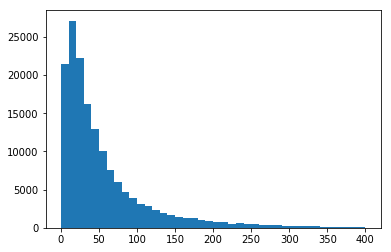

In [12]:
# Have a look at the distribution of number of words in each doc
totalNumWords = [len(one_comment) for one_comment in list_tokenized_docs]
plt.hist(totalNumWords, bins = np.arange(0,410,10))
plt.show()

In [13]:
def split_data(docs, targets):
        length = len(docs)
        split_point = int(round(length * 0.8))
        return docs[:split_point], targets[:split_point], docs[split_point:], targets[split_point:]
    
train_valid_docs, train_valid_targets, test_docs, test_targets = split_data(X_t, list_labels)
train_docs, train_targets, valid_docs, valid_targets = split_data(train_valid_docs, train_valid_targets)

In [14]:
# Tell keras to infer the input shape, in our case it is 200

# We construct the LSTM network here

inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [ ]:
batch_size = 32
epochs = 2

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='saved_models/LSTM.hdf5', verbose=1, save_best_only=True)

model.fit(train_docs, train_targets, validation_data=(valid_docs, valid_targets), 
        epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 102126 samples, validate on 25531 samples
Epoch 1/2
102126/102126 [==============================] - 1040s - loss: 0.0762 - acc: 0.9762 - val_loss: 0.0499 - val_acc: 0.9820
Epoch 2/2
102126/102126 [==============================] - 1034s - loss: 0.0465 - acc: 0.9829 - val_loss: 0.0513 - val_acc: 0.9816


In [15]:
model.load_weights('saved_models/LSTM.hdf5')

evaluation = predictive_evaluate(test_docs, test_targets, model)
print('checkpoint')
print(len(test_docs))
print(len(test_targets))
predictions = np.array(evaluation.get_multilabel_predictions()).astype(int)

print(predictions[200:230])

model_recall_score = recall_score(np.array(test_targets), predictions, average=None)
model_precision_score = precision_score(np.array(test_targets), predictions, average=None)
model_fbeta_score = fbeta_score(np.array(test_targets), predictions, average='weighted', beta=1)

checkpoint
31914
31914
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
print(model_recall_score)
print(model_precision_score)
print(model_fbeta_score)

[0.57853145 0.07395498 0.65787897 0.         0.52591656 0.        ]
[0.68928992 0.63888889 0.78372591 0.         0.71724138 0.        ]
0.5868524223977268
